In [1]:
import timm
import json
from torch.utils.data import Dataset, DataLoader
import torch
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from spam.augmentation import RandAugment, Cutout
import numpy as np

In [2]:
transform_train = transforms.Compose([
    RandAugment(),
    transforms.Resize(size=(224, 244)),
    transforms.RandomHorizontalFlip(),
    Cutout(size=80),
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))]
)

transform_test = transforms.Compose([
    transforms.Resize(size=(224, 244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))]
)

In [3]:
with open('/opt/ml/detection/dataset/train_split1.json', 'r') as f:
    train_json_file = json.load(f)

with open('/opt/ml/detection/dataset/val_split1.json', 'r') as f:
    val_json_file = json.load(f)

In [4]:
len(train_json_file['annotations']) + len(train_json_file['images']), len(val_json_file['annotations']) + len(val_json_file['images'])

(37634, 5959)

In [5]:
id_ = max(anno['id'] for anno in train_json_file['annotations'])

for img in train_json_file['images']:
    id_ += 1
    w = np.random.randint(30, 500)
    h = w  *np.clip(np.random.rand()*2, 0.5, 2)
    anno = {'image_id': img['id'],
            'category_id': 10,
            'area': w*h,
            'bbox': [0, 0, w, h],
            'iscrowd': 0,
            'id': id_}
    train_json_file['annotations'].append(anno)
    
id_ = max(anno['id'] for anno in val_json_file['annotations'])

for img in val_json_file['images']:
    id_ += 1
    w = np.random.randint(30,500)
    h = w*np.random.rand()*2
    anno = {'image_id': img['id'],
            'category_id': 10,
            'area': w*h,
            'bbox': [0, 0, w, h],
            'iscrowd': 0,
            'id': id_}
    val_json_file['annotations'].append(anno)

In [6]:
len(train_json_file['annotations']), len(val_json_file['annotations'])

(37634, 5959)

In [7]:
class TrainDataset(Dataset):

    def __init__(self, json_file, transform):
        
        images = {}
        for img in json_file['images']:
            images[img['id']] = img['file_name']
        
        root = '/opt/ml/detection/dataset/'
        self.annotations = json_file['annotations']
        for anno in self.annotations:
            anno['img_path'] = os.path.join(root, images[anno['image_id']])
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        
        anno = self.annotations[idx]
        img_path = anno['img_path']
        x1, y1, w, h = anno['bbox']
        img = Image.open(img_path).convert('RGB')
        img = img.crop((x1-w*0.05, y1-h*0.05, x1 + 1.05* w ,y1 + 1.05*h))
        img = self.transform(img)
        
        return img, anno['category_id']
    
class TestDataset(Dataset):

    def __init__(self, json_file, transform):

        images = {}
        for img in json_file['images']:
            images[img['id']] = img['file_name']
        
        root = '/opt/ml/detection/dataset/'
        self.annotations = json_file['annotations']
        for anno in self.annotations:
            anno['img_path'] = os.path.join(root, images[anno['image_id']])
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        
        anno = self.annotations[idx]
        img_path = anno['img_path']
        x1, y1, w, h = anno['bbox']
        img = Image.open(img_path).convert('RGB')
        img = img.crop((x1-w*0.05, y1-h*0.05, x1 + 1.05* w ,y1 + 1.05*h))
        img = self.transform(img)
        
        return img, anno['category_id']

In [8]:
ds_train = TrainDataset(train_json_file, transform_train)
ds_val = TrainDataset(val_json_file, transform_test)

In [10]:
device = 'cuda'
batch_size = 64
lr = 0.00006
num_epoch = 30

In [11]:
dataloaders = {
                'train' : DataLoader(ds_train, batch_size=batch_size, num_workers=4, drop_last=True, shuffle=True),
                'valid' : DataLoader(ds_val, batch_size=batch_size, num_workers=4, drop_last=False, shuffle=False),
              }

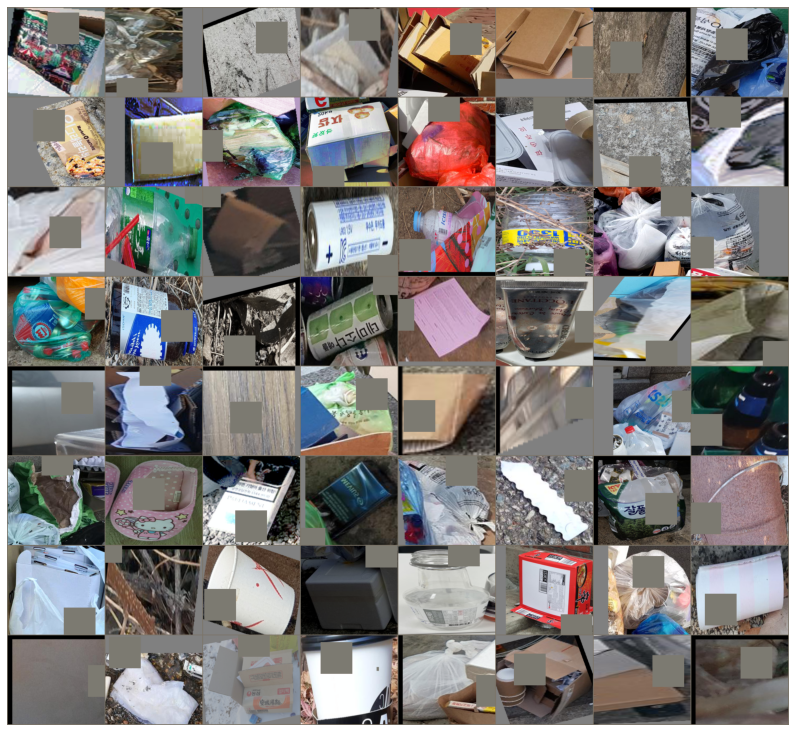

tensor([ 1,  5, 10,  6,  1,  1, 10,  7,  7,  1,  7,  1,  7,  1, 10,  7,  7,  5,
         1,  8,  7,  5,  7,  7,  7,  4, 10,  3,  1,  5,  7,  0, 10,  1, 10,  7,
         1,  6,  7,  4,  1,  9,  0,  0,  7,  0,  7,  3,  1, 10,  2,  6,  4,  1,
         7,  0, 10,  0,  1,  2,  7,  1,  4, 10])


In [12]:
from spam.utils import imshow
a = iter(dataloaders['train'])
batch = next(a)
imshow(batch[0])
print(batch[1])

In [13]:
model = timm.create_model('tf_efficientnet_b0', pretrained=True, num_classes=11)
model.to(device)
print('ready')

ready


In [14]:
import torch.optim as optim
from spam.loss import LabelSmoothing

criterion = LabelSmoothing(0.1)
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = None

In [15]:
from spam.trainer import Trainer

trainer = Trainer('/opt/ml/detection/ensemble/save', seed=4)

In [16]:
trainer.train(model, dataloaders, criterion, optimizer, num_epoch, 3, 'split1')

Epoch 1/30
----------


100%|██████████| 588/588 [04:34<00:00,  2.14it/s]


train Epoch: 1 Loss: 1.5453 Acc: 0.6159 F1: 0.4662


100%|██████████| 94/94 [00:35<00:00,  2.66it/s]


valid Epoch: 1 Loss: 1.3899 Acc: 0.6580 F1: 0.5754

Epoch 2/30
----------


100%|██████████| 588/588 [04:37<00:00,  2.12it/s]


train Epoch: 2 Loss: 1.1107 Acc: 0.7630 F1: 0.6952


100%|██████████| 94/94 [00:35<00:00,  2.66it/s]


valid Epoch: 2 Loss: 1.2488 Acc: 0.7093 F1: 0.6514

Epoch 3/30
----------


100%|██████████| 588/588 [04:37<00:00,  2.12it/s]


train Epoch: 3 Loss: 0.9982 Acc: 0.8077 F1: 0.7631


100%|██████████| 94/94 [00:35<00:00,  2.63it/s]


valid Epoch: 3 Loss: 1.1835 Acc: 0.7302 F1: 0.6816

Epoch 4/30
----------


100%|██████████| 588/588 [04:37<00:00,  2.12it/s]


train Epoch: 4 Loss: 0.9304 Acc: 0.8376 F1: 0.8033


100%|██████████| 94/94 [00:34<00:00,  2.69it/s]


valid Epoch: 4 Loss: 1.1487 Acc: 0.7449 F1: 0.7093

Epoch 5/30
----------


100%|██████████| 588/588 [04:38<00:00,  2.11it/s]


train Epoch: 5 Loss: 0.8823 Acc: 0.8560 F1: 0.8314


100%|██████████| 94/94 [00:35<00:00,  2.63it/s]


valid Epoch: 5 Loss: 1.1345 Acc: 0.7538 F1: 0.7141

Epoch 6/30
----------


100%|██████████| 588/588 [04:38<00:00,  2.11it/s]


train Epoch: 6 Loss: 0.8409 Acc: 0.8744 F1: 0.8522


100%|██████████| 94/94 [00:35<00:00,  2.67it/s]


valid Epoch: 6 Loss: 1.1224 Acc: 0.7575 F1: 0.7247

Epoch 7/30
----------


100%|██████████| 588/588 [04:38<00:00,  2.11it/s]


train Epoch: 7 Loss: 0.8028 Acc: 0.8913 F1: 0.8762


100%|██████████| 94/94 [00:34<00:00,  2.71it/s]


valid Epoch: 7 Loss: 1.1287 Acc: 0.7547 F1: 0.7251

Epoch 8/30
----------


100%|██████████| 588/588 [04:39<00:00,  2.10it/s]


train Epoch: 8 Loss: 0.7759 Acc: 0.9045 F1: 0.8931


100%|██████████| 94/94 [00:35<00:00,  2.68it/s]


valid Epoch: 8 Loss: 1.1250 Acc: 0.7614 F1: 0.7326

Epoch 9/30
----------


100%|██████████| 588/588 [04:38<00:00,  2.11it/s]


train Epoch: 9 Loss: 0.7453 Acc: 0.9210 F1: 0.9119


100%|██████████| 94/94 [00:35<00:00,  2.61it/s]


valid Epoch: 9 Loss: 1.1303 Acc: 0.7594 F1: 0.7223

Epoch 10/30
----------


100%|██████████| 588/588 [04:36<00:00,  2.12it/s]


train Epoch: 10 Loss: 0.7190 Acc: 0.9320 F1: 0.9249


100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


valid Epoch: 10 Loss: 1.1404 Acc: 0.7614 F1: 0.7289

Epoch 11/30
----------


100%|██████████| 588/588 [04:38<00:00,  2.11it/s]


train Epoch: 11 Loss: 0.7019 Acc: 0.9411 F1: 0.9364


100%|██████████| 94/94 [00:34<00:00,  2.72it/s]


valid Epoch: 11 Loss: 1.1442 Acc: 0.7632 F1: 0.7314

Epoch 12/30
----------


100%|██████████| 588/588 [04:35<00:00,  2.13it/s]


train Epoch: 12 Loss: 0.6837 Acc: 0.9499 F1: 0.9451


100%|██████████| 94/94 [00:35<00:00,  2.62it/s]

valid Epoch: 12 Loss: 1.1446 Acc: 0.7634 F1: 0.7263

Training complete!
Best f1 score 0.7326 at epoch 8

